# RGR Stock Price Forecasting Project - Part 1

Author: Jack Wang

---

## Problem Statement

Stock prices are hard to predict because they are not only affected by the performance of the underlying companies but also the expectations from the general public. As known, the stock price of firearm companies are highly correlated to the public opinions toward gun control. My model intends to predict the stock price of one of the largest firearm company in the states, RGR (Sturm, Ruger & Co., firearm company), by using its historical stock price, public opinions toward gun control, and its financial reports to SEC. 

## Executive Summary

The goal of my project is to build a **time series regression model** that predicts the stock price of RGR. The data I am using would be historical stock price from [Yahoo Finance](https://finance.yahoo.com/quote/RGR/history?p=RGR), twitter posts scraped from [twitter](https://twitter.com/), subreddit posts mentioned about gun control, and also the financial reports to [SEC](https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000095029&type=&dateb=&owner=exclude&count=100). I will do sentiment analysis on the text data and time series modeling on the historical stock price data. The model will be evaluated using MSE.

## Content

This project consists of 7 Jupyter notebooks:
- ***Part-1-stock-price-data***
    - [Data Import & Cleaning](#Data-Import-&-Cleaning)
    - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [ARIMA Model](#ARIMA-Model)
    - [SARIMA Model](#SARIMA-Model)
- Part-2-twitter-scraper
- Part-3-twitter-data-cleaning
- Part-4-reddit-data-scraper
- Part-5-reddit-data-cleaning
- Part-6-sec-data-cleaning
- Part-7-modeling-and-evaluation


---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('fivethirtyeight')

### Data Import & Cleaning

RGR historical stock prices are downloaded directly from Yahoo Finance

In [2]:
df_1 = pd.read_csv("../data/stock_price/RGR-2014-2018.csv")
df_2 = pd.read_csv("../data/stock_price/RGR-2019.csv")

In [3]:
df = pd.merge(df_1, df_2, how = 'outer')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.shape

(1470, 7)

In [6]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,73.129997,74.000000,72.459999,73.750000,64.496201,373800
1,2014-01-03,73.709999,74.269997,73.220001,73.739998,64.487442,427200
2,2014-01-06,73.779999,75.750000,73.769997,74.019997,64.732330,318500
3,2014-01-07,75.750000,76.620003,74.459999,76.519997,66.918625,507000
4,2014-01-08,77.370003,79.269997,76.830002,78.980003,69.069954,665800


In [9]:
# Export combined data
df.to_csv("../data/stock_price/stock_price_2014_to_2019.csv", index=False)

### Exploratory Data Analysis

In [10]:
df = df.set_index('Date')

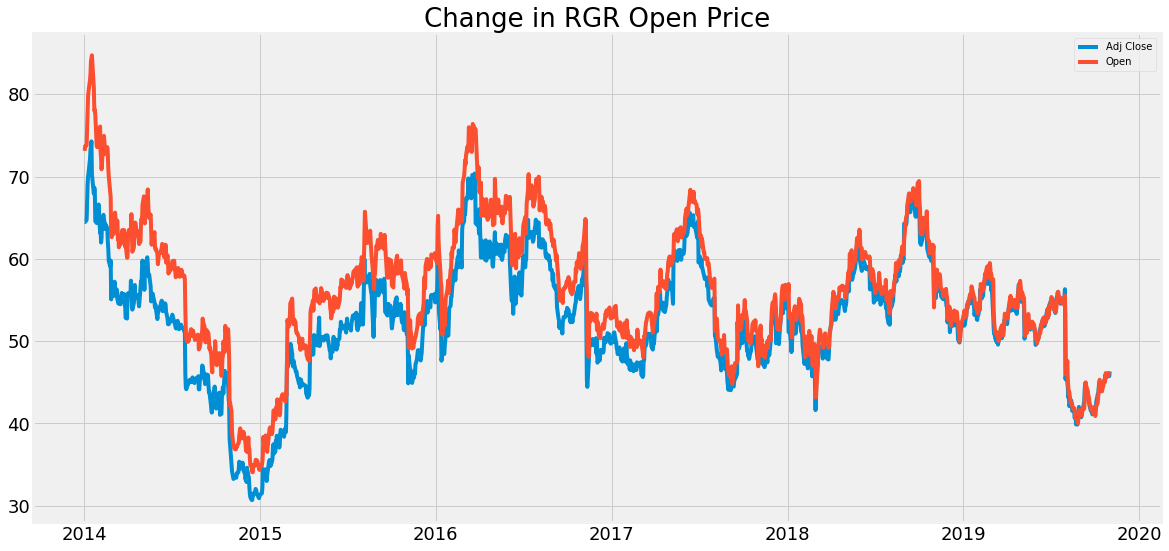

In [11]:
# Create a function that plots time series data

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        plt.plot(df[col], label=col)
    plt.legend()
    
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

plot_series(df, ['Adj Close','Open'], title ='Change in RGR Open Price')

Adjusted closing price and open price follow a similar shape and trend. Adjusted close price takes into account for other aspects of the stock and is considered more accurate to the stock price value. However, since our final goal is to predict the money value of the stock, we will set `Open` price as our target.

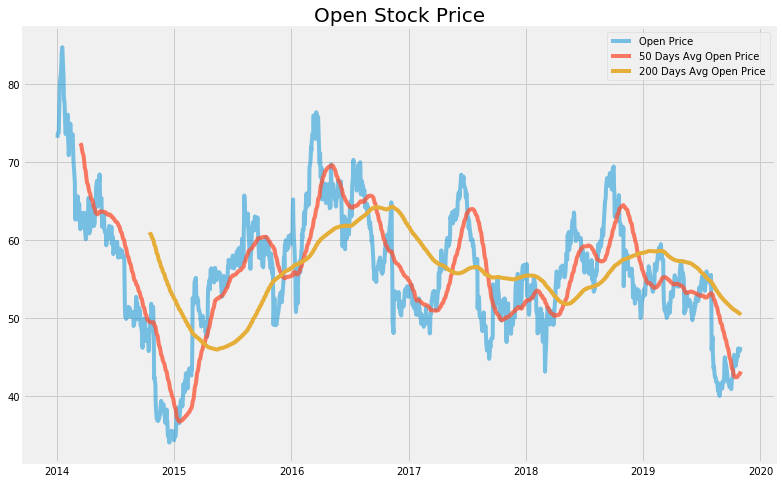

In [12]:
# Compare and plot the rolling prices
plt.figure(figsize=(12,8))
plt.plot(df['Open'],alpha = 0.5, label = "Open Price")
plt.plot(df['Open'].rolling(50).mean(), alpha = 0.75, label = "50 Days Avg Open Price")
plt.plot(df['Open'].rolling(200).mean(), label = "200 Days Avg Open Price")
plt.title("Open Stock Price", size = 20)
plt.legend();

***Golden Cross & Death Cross***
When the red line (50 days avg) goes above the yellow line (200 days avg), there is a strong indication for upward trend. It is so-called `Golden Cross`. On the other hand, when the red line goes below the yellow line, it is an indication for downward trend. It is called `Death Cross`. More information can be found [here](https://www.investopedia.com/ask/answers/121114/what-difference-between-golden-cross-and-death-cross-pattern.asp).

Text(0.5, 1.0, 'Open Price Percentage Difference')

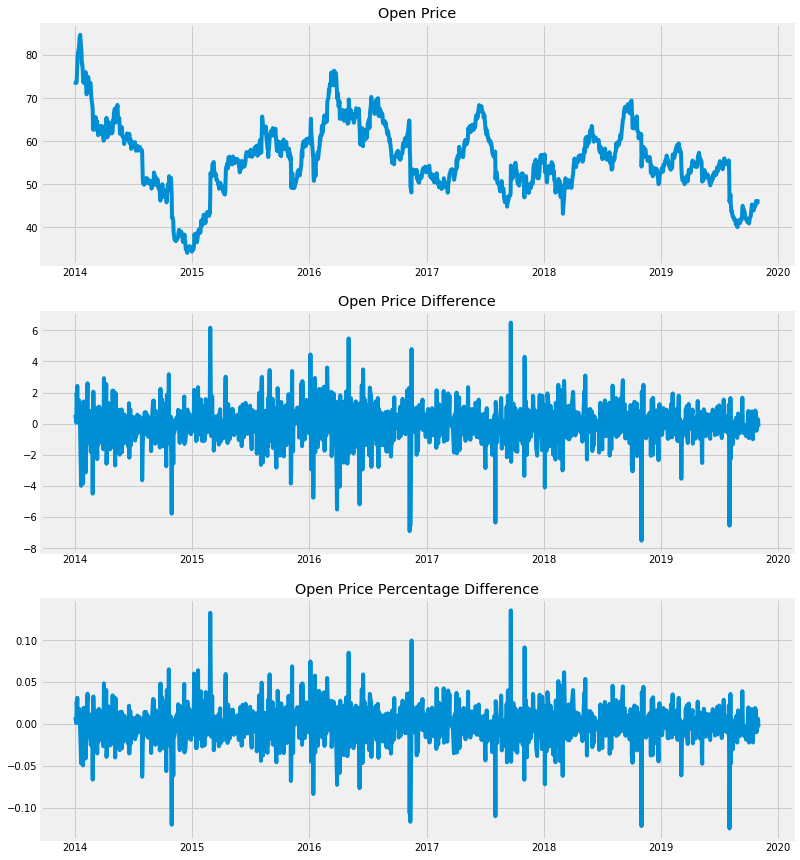

In [13]:
# Open price, open price with diffence, open price with percentage difference

fig, axes = plt.subplots(nrows = 3, figsize = (12, 15))
axes[0].plot(df['Open'])
axes[0].set_title('Open Price')
axes[1].plot(df['Open'].diff())
axes[1].set_title('Open Price Difference')
axes[2].plot(df['Open'].pct_change())
axes[2].set_title('Open Price Percentage Difference')

I will predict the model using `open price`. Using the difference or percentage difference does not seem necessary here. There is no long-term upward/downward trending that might result in unseen data.

''

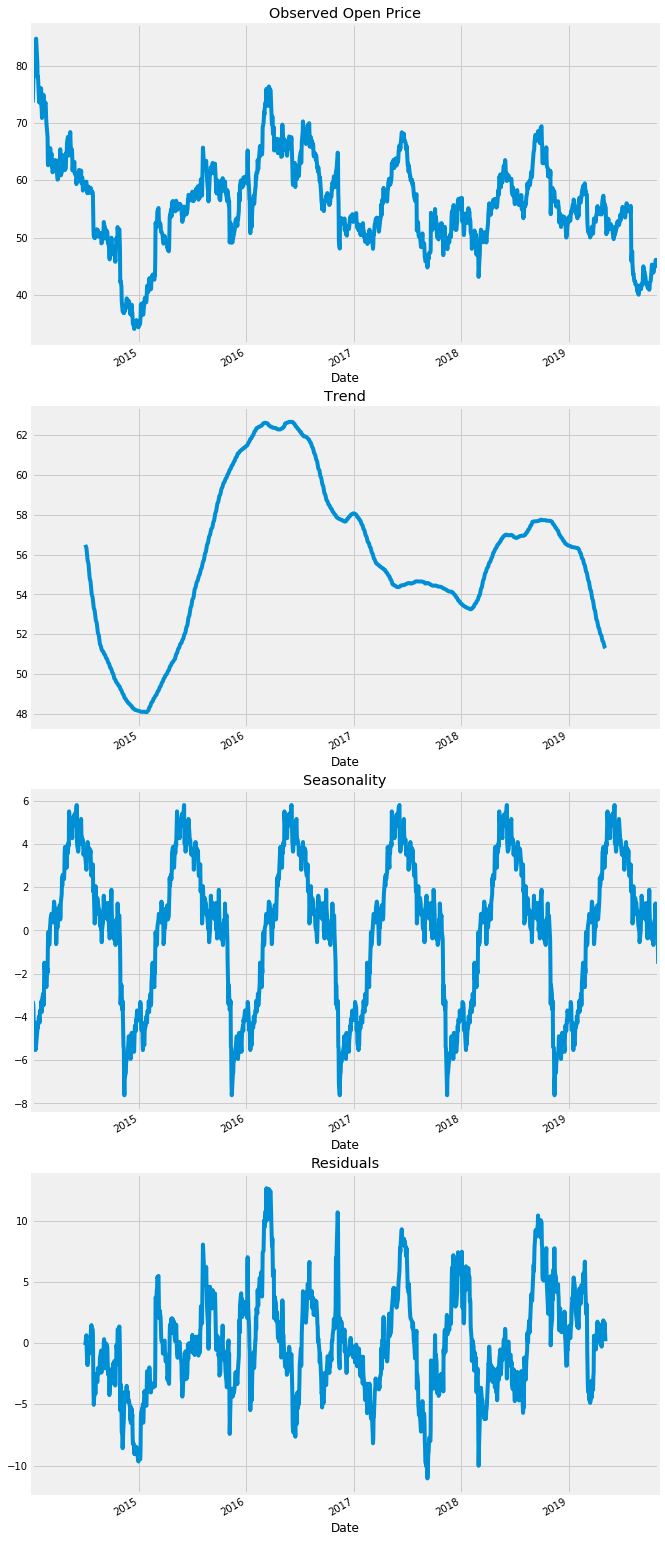

In [14]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df['Open'], freq = 252)
# Plot the decomposed time series.
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,30))
decomp.observed.plot(ax=ax1)
ax1.set_title('Observed Open Price')
decomp.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomp.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
decomp.resid.plot(ax=ax4)
ax4.set_title('Residuals')
;

### ARIMA Model

In [15]:
train = df['2014':'2018']['Open']
test = df['2019']['Open']

In [16]:
# Code written by Joseph Nelson

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [17]:
# Run ADF test on original (non-differenced!) data.

interpret_dftest(adfuller(train))

Test Statistic   -3.077299
p-value           0.028279
dtype: float64

Our data is stationary. No need to difference the data.

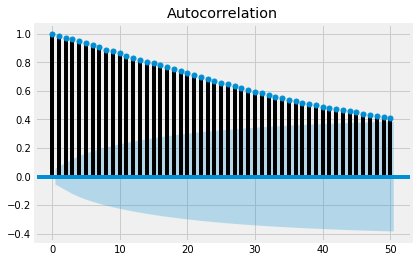

In [18]:
plot_acf(train, lags = 50);

Based on the above ACF, the q value for our ARIMA model should be 0.

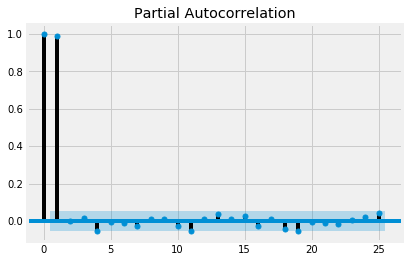

In [19]:
plot_pacf(train, lags = 25);

Based on above PACF, the p for our ARIMA model should be 1

In [20]:
# Instantiate model.

model = ARIMA(endog = train, order = (1, 0, 0))

# Fit model.
arima_1_0_0 = model.fit()

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


**Prediction**

In [21]:
# Generate predictions.
arima_1_0_0_preds = model.predict(params=arima_1_0_0.params,
                      start=1259,
                      end=1259+210)

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Plotting the predictions with test data

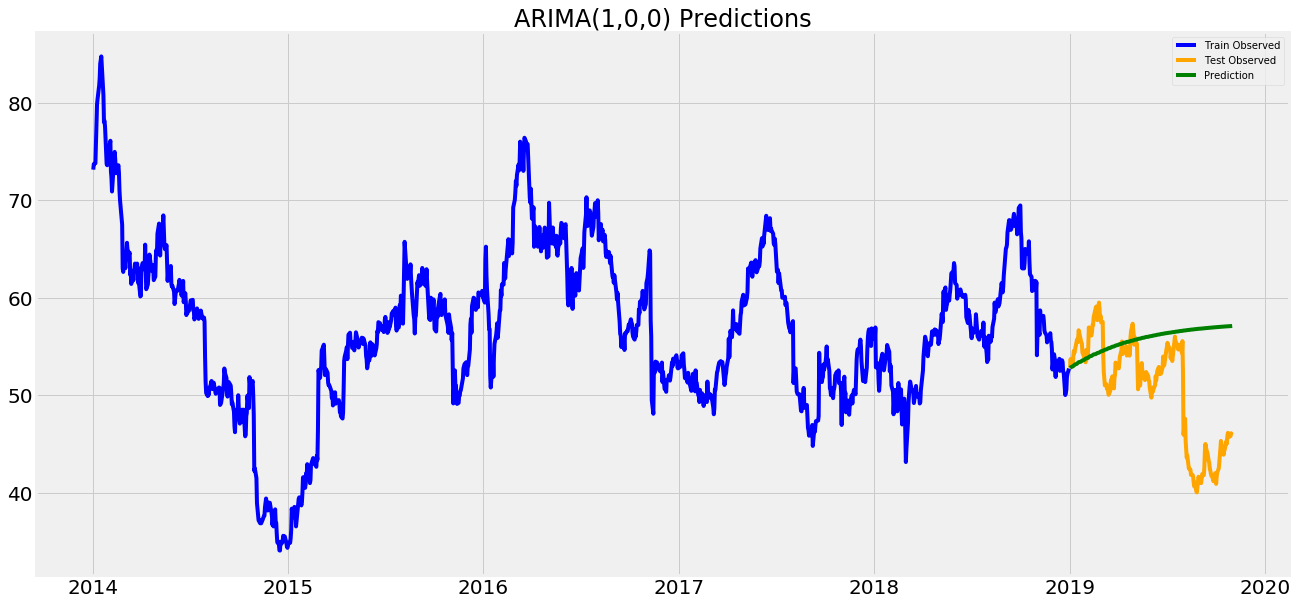

In [22]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, pd.DataFrame(train), color = 'blue')

# Plot testing data.
plt.plot(test.index, pd.DataFrame(test), color = 'orange')

# Plot predicted test values.
plt.plot(test.index, pd.DataFrame(arima_1_0_0_preds), color = 'green')

# Set label.
plt.title(label = 'ARIMA(1,0,0) Predictions', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [23]:
# MSE
mean_squared_error(pd.DataFrame(test), arima_1_0_0_preds)

64.78225546461476

It is obvious that our ARIMA model is not doing well. Although the MSE of the model is not too high, it completely mis-predicts the trend (As shown above).

### SARIMA Model

Let's see if adding the seasonal component to our model would help. Instead of hand picking the PDQ values, I will GrideSearch the best params.

In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
print(f'possible params are: {seasonal_pdq}')

possible params are: [(0, 0, 0, 5), (0, 0, 1, 5), (0, 1, 0, 5), (0, 1, 1, 5), (1, 0, 0, 5), (1, 0, 1, 5), (1, 1, 0, 5), (1, 1, 1, 5)]


In [25]:
# Iterate through all the possible params and print out the AIC score (the lower the better)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC: 13749.68507518579


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC: 12065.643805647349
ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC: 6115.888808331418
ARIMA(0, 0, 0)x(0, 1, 1, 5) - AIC: 6068.508726776787


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 5) - AIC: 6122.852767325333


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 5) - AIC: 6113.05987669467
ARIMA(0, 0, 0)x(1, 1, 0, 5) - AIC: 6075.351088461305


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC: 6070.149395191888


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 5) - AIC: 12036.2723890899


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 5) - AIC: 10617.667565298703
ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC: 5368.1043964402215


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC: 5280.941472608052


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 5) - AIC: 5383.257932782923


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 5) - AIC: 5390.156948980141
ARIMA(0, 0, 1)x(1, 1, 0, 5) - AIC: 5293.739660808681


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 5) - AIC: 5280.452173532452
ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC: 4159.85973368492
ARIMA(0, 1, 0)x(0, 0, 1, 5) - AIC: 4142.09738032909
ARIMA(0, 1, 0)x(0, 1, 0, 5) - AIC: 5024.880749757116


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has n

ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC: 4154.6345167927375
ARIMA(0, 1, 0)x(1, 0, 0, 5) - AIC: 4144.674373861904


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 5) - AIC: 4143.8160670447505
ARIMA(0, 1, 0)x(1, 1, 0, 5) - AIC: 4605.345365585163


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 5) - AIC: 4153.617843623037
ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC: 4159.313674650675
ARIMA(0, 1, 1)x(0, 0, 1, 5) - AIC: 4140.195645491976


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 5) - AIC: 5022.944762654685


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC: 4144.689045801477
ARIMA(0, 1, 1)x(1, 0, 0, 5) - AIC: 4146.2628731805025


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 5) - AIC: 4141.941768043949
ARIMA(0, 1, 1)x(1, 1, 0, 5) - AIC: 4607.162985222436


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 5) - AIC: 4143.3765624916205
ARIMA(1, 0, 0)x(0, 0, 0, 5) - AIC: 4163.588592314695


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 5) - AIC: 4145.405471903648
ARIMA(1, 0, 0)x(0, 1, 0, 5) - AIC: 4888.689786235109


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 5) - AIC: 4150.132283524263


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 5) - AIC: 4145.483188066054


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 5) - AIC: 4146.9862995508165


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 5) - AIC: 4523.721546288492


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 5) - AIC: 4147.694062714837
ARIMA(1, 0, 1)x(0, 0, 0, 5) - AIC: 4162.802914001577


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 5) - AIC: 4144.397695510488
ARIMA(1, 0, 1)x(0, 1, 0, 5) - AIC: 4877.1790102607265


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 5) - AIC: 4149.341952296247


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 5) - AIC: 4147.055639898474


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 5) - AIC: 4146.042592147746


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 5) - AIC: 4522.506096457635


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 5) - AIC: 4146.368019891903
ARIMA(1, 1, 0)x(0, 0, 0, 5) - AIC: 4161.6392554479935
ARIMA(1, 1, 0)x(0, 0, 1, 5) - AIC: 4143.705225701703


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 5) - AIC: 5026.4946818731405


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 5) - AIC: 4156.633828782906
ARIMA(1, 1, 0)x(1, 0, 0, 5) - AIC: 4143.769863356019


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 5) - AIC: 4145.415187475319
ARIMA(1, 1, 0)x(1, 1, 0, 5) - AIC: 4604.465015375699


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 5) - AIC: 4155.292200752189


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 5) - AIC: 4160.379865065933


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 5) - AIC: 4142.468472391885
ARIMA(1, 1, 1)x(0, 1, 0, 5) - AIC: 5012.522595273425


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 5) - AIC: 4145.518568592806


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 5) - AIC: 4145.251940939752


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 5) - AIC: 4144.156929563747


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 5) - AIC: 4604.791227763118


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 5) - AIC: 4145.7275401704155


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


**The best SARIMA model is ARIMA(0, 1, 1)x(0, 0, 1, 5) with AIC score 4140.195645491976**

In [26]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 5),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0192      0.024     -0.806      0.420      -0.066       0.027
ma.S.L5       -0.0140      0.030     -0.467      0.641      -0.073       0.045
sigma2         1.5991      0.035     46.164      0.000       1.531       1.667


**As we can see, the p-value for all features are pretty high. We can conclude this model is performing poorly.**

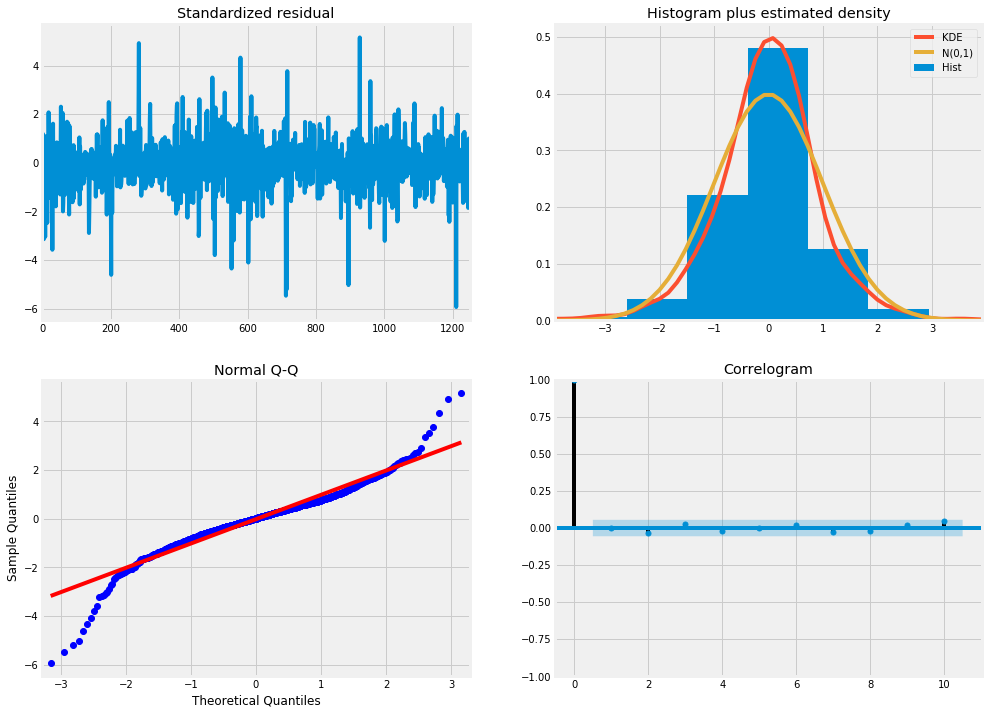

In [27]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**The above plot shows that the residuals of our model are not normally distributed well. We should improve on our model. Our ultimate goal is to have uncorrelated residuals and normally distributed residuals.**

In [28]:
sarima_preds = results.predict(params=results.params,
                      start=1259,
                      end=1259+211)

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


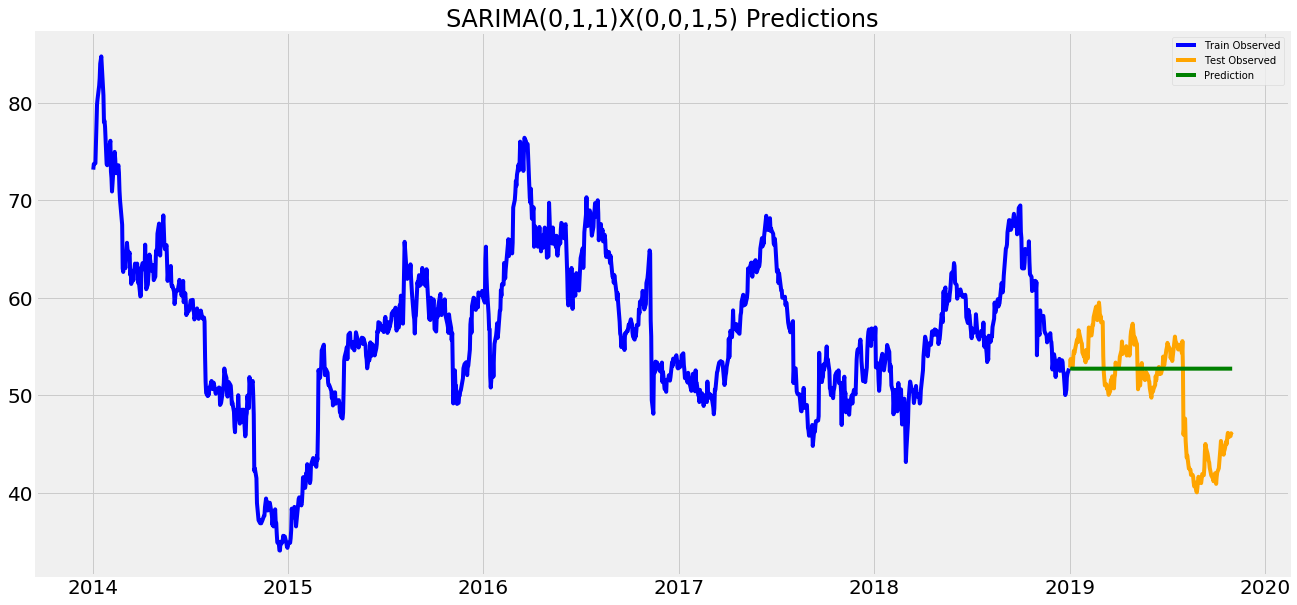

In [29]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, pd.DataFrame(train), color = 'blue')

# Plot testing data.
plt.plot(test.index, pd.DataFrame(test), color = 'orange')

# Plot predicted test values.
plt.plot(test.index, pd.DataFrame(sarima_preds), color = 'green')

# Set label.
plt.title(label = 'SARIMA(0,1,1)X(0,0,1,5) Predictions', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [30]:
# MSE
mean_squared_error(pd.DataFrame(test), sarima_preds)

33.33824584819686

Our MSE improves a little bit comparing to our ARIMA model. However, the SARIMA model is almost like predicting the mean. So it is a bad model. 

**The conclusion is that we cannot forecast well with only the historical stock price, we have to include other factors (eXogenous).**

# Price Only with LSTM Model

### 

In [1]:
example_1 = {'a': 3, 'b': 4, 'c': 5}
example_2 = {'a': 2, 'b': 4, 'c': 5}
example_3 = {'a': 3, 'b': 4, 'c': 5, 'd':6}



In [2]:
example_1 == example_2

False

In [3]:
example_1 == example_1

True

In [20]:
def anagramSolution(s1, s2):
    s1_dict = {}
    s2_dict = {}
    
    for ch in s1:
        if ch in s1_dict:
            s1_dict[ch] += 1
        else:
            s1_dict[ch] = 1
    
    for ch in s2:
        if ch in s2_dict:
            s2_dict[ch] += 1
        else:
            s2_dict[ch] = 1

    return s1_dict == s2_dict

In [27]:
test_cases = (('apple', 'pplea', True),
              ('abc', 'c', False),
              ('adc', 'cda', True),
              ('abc', '', False),
              ('','',True),
              ('appple', 'apple', False)
             )

for s1, s2, result in test_cases:
    assert anagramSolution(s1, s2) == result, "Something wrong"

## Task

In [34]:
import timeit
import random

In [55]:
def list_index(n):
    some_list = [x for x in range(0,n)]
    k = random.choice(range(0,n))
    return some_list[k-1]

In [51]:
t1 = timeit.Timer('list_index(1000)','from __main__ import list_index')

In [56]:
list_index(100)

45

In [59]:
t1.timeit(number = 1000)/1000

5.619765000301413e-05

In [60]:
t1.timeit(number = 1000000)/1000000

3.827889161300118e-05

## Stack Implementation

In [104]:
class Stack:
    def __init__(self):
        self._items = []
        
    def push(self, item):
        self._items.append(item)
    
    def pop(self):
        last_item = self._items[-1]
        self._items.pop()
        return last_item
    
    def peek(self):
        return self._items[-1]
    
    def is_empty(self):
        return not bool(self._items)
    
    def size(self):
        return len(self._items)

In [112]:
s = Stack()

print(s.is_empty())
s.push(4)
s.push("dog")
print(s.peek())
s.push(True)
print(s.size())
print(s.is_empty())
s.push(8.4)
print(s.pop())
print(s.pop())
print(s.size())


True
dog
3
False
8.4
True
2


## Queue

In [116]:
class Queue:
    def __init__(self):
        self._items = []
        
    def enqueue(self, item):
        self._items.insert(0, item)
    
    def dequeue(self):
        return self._items.pop() 
        
    def is_empty(self):
        return not bool(self._items)
    
    def size(self):
        return len(self._items)

In [117]:
q = Queue()
q.enqueue(4)
q.enqueue("dog")
q.enqueue(True)
print(q.size())

3


## Deque

In [132]:
class Deque:
    def __init__(self):
        self._items = []
        
    def add_front(self, item):
        self._items.append(item)
        
    def add_rear(self, item):
        self._items.insert(0, item)
        
    def is_empty(self):
        return not bool(self._items)
    
    def remove_front(self):
        return self._items.pop()
    
    def remove_rear(self):
        return self._items.pop(0)
    
    def size(self):
        return len(self._items)
    
    

In [133]:
d=Deque()
print(d.is_empty())
d.add_rear(4)
d.add_rear('dog')
d.add_front('cat')
d.add_front(True)
print(d.size())
print(d.is_empty())
d.add_rear(8.4)
print(d.remove_rear())
print(d.remove_front())

True
4
False
8.4
True


## Linked List

In [151]:
class Node():
    def __init__(self, data):
        self.data = data
        self.next = None

In [152]:
temp = Node(93)

In [158]:
temp.next = Node(80)

In [163]:
temp.next.data

80

In [356]:
class UnorderedList():
    def __init__(self):
        self.head = None
        
    def is_empty(self):
        return bool(self.head == None)
    
    def add(self, value):
        temp = Node(value)
        temp.next = self.head
        self.head = temp
        
    def size(self):
        current = self.head
        counter = 0
        while current != None:
            counter += 1
            current = current.next
        return counter
    
    def search(self, item):
        current = self.head
        while current != None:
            if current.data == item:
                return True
            current = current.next
        return False
    
    def remove(self, item):
        current = self.head
        if current.data == item:
            temp = current.next
            self.head = temp
            return
        while current != None:
            print(current.next.data)
            if current.next.data == item:
                temp = current.next.next
                current.next = temp
                break
            current = current.next

    def append(self, item):
        

In [357]:
some_list = UnorderedList()

In [358]:
some_list.is_empty()

True

In [359]:
some_list.add(10)
some_list.add(20)
some_list.add(30)

In [360]:
some_list.size()

3

In [361]:
some_list.search(10)

True

In [362]:
some_list.remove(10)

20
10


In [363]:
some_list.size()

2

In [367]:
some_list.head.next.next

In [368]:
s = '123'
s[1:2]

'2'

In [378]:
def reverse(s): 
  str = "" 
  for i in s: 
    str = i + str
  return str

In [379]:
s = 'abc'

In [380]:
reverse(s)

'cba'